# Utilities

In [25]:
def to_vector(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return ((x2 - x1), (y2 - y1))

def vec_angle(p1_1, p1_2, p2_1, p2_2):
    x1, y1 = to_vector(p1_1, p1_2)
    x2, y2 = to_vector(p2_1, p2_2)
    return (x1*x2 + y1*y2) / (((x1*x1 + y1*y1) * (x2*x2 + y2*y2))**0.5)

def find_normal(line_point1, line_point2, point):
    x1, y1 = line_point1
    x2, y2 = line_point2
    x3, y3 = point
    
    dx = x2 - x1
    dy = y2 - y1
    
    mag = (dx*dx + dy*dy)**0.5
    dx /= mag
    dy /= mag
    
    lambd = (dx * (x3 - x1)) + (dy * (y3 - y1))
    x4 = (dx * lambd) + x1
    y4 = (dy * lambd) + y1
    res = (x4, y4)
    
#     print("normal:", f"x1,y1: {line_point1}, x2,y2: {line_point2}", f"x3,y3: {point}", f"mag: {mag}, lambd: {lambd}", f"res: {res}")
    return res

In [2]:
def video_to_images(video_path, out_path):
    vidcap = cv.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    while success:
        cv.imwrite(f"{out_path}/frame_{count:0>3d}.jpg", image) # save frame as JPEG file      
        success, image = vidcap.read()
        print('Read a new frame: ', success)
        count += 1
    
#video_to_images('videos/short_next_1forward.mp4', './')
# video_to_images(f"{SHORT_NEXT_4_INCORRECT}.mp4", f"{SHORT_NEXT_4_INCORRECT}")

In [71]:
# mp.__file__
#!pip install ipywebrtc

'/home/pihanya/anaconda3/lib/python3.8/site-packages/mediapipe/__init__.py'

# CS6643 Final Project: Pose Estimation and Matching

### Matthew Avallone, Siddharth Choudhary, Kshitija Patel

In [3]:
!pip install mediapipe

In [4]:
import utils

import mediapipe as mp
from mediapipe.python.solutions.pose import PoseLandmark
import cv2 as cv
import cv2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import time
from pathlib import Path
import math

In [5]:
VIDEOS_FOLDER = Path("./videos")

SHORT_NEXT_1FORWARD = VIDEOS_FOLDER / "short_next_1forward"
SHORT_NEXT_1LEFT = VIDEOS_FOLDER / "short_next_2left"
SHORT_NEXT_4_INCORRECT = VIDEOS_FOLDER / "short_next_4incorrect"

FRAME_PATTERN = "frame_*.jpg"

### Load Images

In [30]:
#frame1 = cv.imread(f"images/running1.jpg") # input
frame1 = cv.imread(str(SHORT_NEXT_1FORWARD / "frame_000.jpg"))

#frame1 = cv.imread(f"images/running2.jpg") # output
frame2 = cv.imread(str(SHORT_NEXT_1LEFT / "frame_000.jpg")) # test succ
# frame2 = cv.imread(SHORT_NEXT_1LEFT / "frame_020.jpg") # test fail
# frame2 = cv.imread(SHORT_NEXT_1LEFT / "frame_003.jpg") # test full fail

# Ensure images are the same size
hi = min(frame1.shape[0], frame2.shape[0])
wi = min(frame1.shape[1], frame2.shape[1])

frame1 = cv.resize(frame1, (wi,hi))
frame2 = cv.resize(frame2, (wi,hi))

# Visualize images
fig = plt.figure(figsize = (10,20))

plt.subplot(121)
plt.imshow(frame1[:,:,::-1])

plt.subplot(122)
plt.imshow(frame2[:,:,::-1])

NameError: name 'cv' is not defined

In [7]:
frameWidth = frame1.shape[1]
frameHeight = frame1.shape[0]

### Similarity/visualization

Hence we initialize a dictionary and 2D array to be able to mark these points on our image and connect them easily 

In [31]:
def similarity_score(pose1, pose2):
    p1 = []
    p2 = []
    pose_1 = np.array(pose1, dtype=np.float)
    pose_2 = np.array(pose2, dtype=np.float)

    # Normalize coordinates
    pose_1[:,0] = pose_1[:,0] / max(pose_1[:,0])
    pose_1[:,1] = pose_1[:,1] / max(pose_1[:,1])
    pose_2[:,0] = pose_2[:,0] / max(pose_2[:,0])
    pose_2[:,1] = pose_2[:,1] / max(pose_2[:,1])

    # L2 Normalization
#     for joint in range(pose_1.shape[0]):
#         mag1 = float(math.sqrt(pose_1[joint][0]**2 + pose_1[joint][1]**2))
#         mag2 = float(math.sqrt(pose_2[joint][0]**2 + pose_2[joint][1]**2))

#         pose_1[joint][0] = pose_1[joint][0] / mag1
#         pose_1[joint][1] = pose_1[joint][1] / mag2
#         pose_2[joint][0] = pose_2[joint][0] / mag2
#         pose_2[joint][1] = pose_2[joint][1] / mag2

    # Turn (16x2) into (32x1)
    for joint in range(pose_1.shape[0]):
        x1 = pose_1[joint][0]
        y1 = pose_1[joint][1]
        x2 = pose_2[joint][0]
        y2 = pose_2[joint][1]

        p1.append(x1)
        p1.append(y1)
        p2.append(x2)
        p2.append(y2)

    p1 = np.array(p1)
    p2 = np.array(p2)

    # Looking to minimize the distance if there is a match
    # Computing two different distance metrics
    scoreA = utils.cosine_distance(p1, p2)
    scoreB = utils.weight_distance(p1, p2, conf1)

    print("Cosine Distance:", scoreA)
    print("Weighted Distance:", scoreB)

In [32]:
def visualize_output(pose1, pose2, size):
    assert(len(pose1) == len(pose2))
    pose_len = len(pose1)
    
    # Initialize blank canvas
    canvas = np.ones(size)

    # Plot points on images
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        if idFrom >= pose_len:
            continue
        elif idTo >= pose_len:
            continue
        
        if pose1[idFrom] and pose1[idTo]:
            cv.line(canvas, pose1[idFrom], pose1[idTo], (0, 255, 0), 3)
            cv.ellipse(canvas, pose1[idFrom], (4, 4), 0, 0, 360, (0, 255, 0), cv.FILLED)
            cv.ellipse(canvas, pose1[idTo], (4, 4), 0, 0, 360, (0, 255, 0), cv.FILLED)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        if idFrom >= pose_len:
            continue
        elif idTo >= pose_len:
            continue
        
        if pose2[idFrom] and pose2[idTo]:
            cv.line(canvas, pose2[idFrom], pose2[idTo], (255, 0, 0), 3)
            cv.ellipse(canvas, pose2[idFrom], (4, 4), 0, 0, 360, (255, 0, 0), cv.FILLED)
            cv.ellipse(canvas, pose2[idTo], (4, 4), 0, 0, 360, (255, 0, 0), cv.FILLED)

    # Visualize images
    fig3 = plt.figure(figsize = (10,10))
    plt.imshow(canvas[:,:,::-1])
    plt.grid(True)

## Solution 1

In [9]:
# See https://google.github.io/mediapipe/images/mobile/pose_tracking_full_body_landmarks.png
BODY_PARTS = {
    "Head": 25, # Augmented data
    #"Neck": ...,
    #"Neck": 0, # It's a nose actually
    "Neck": 26, # Augmented data
    "RShoulder": 12,
    "RElbow": 14,
    "RWrist": 16,
    "LShoulder": 11,
    "LElbow": 13,
    "LWrist": 15,
    "RHip": 24,
    #"RKnee": 26, # because we're using simplified model
    #"RAnkle": 28, # because we're using simplified model
    "LHip": 23,
    #"LKnee": 25, # because we're using simplified model
    #"LAnkle": 27 # because we're using simplified model
    #"Chest": ...
    "Chest": 27 # Augmented data
    #"Background": ...
}

POSE_PAIRS = [
    ["Head", "Neck"],
    ["Neck", "RShoulder"],
    ["RShoulder", "RElbow"],
    ["RElbow", "RWrist"],
    ["Neck", "LShoulder"],
    ["LShoulder", "LElbow"],
    ["LElbow", "LWrist"],
    ["Neck", "Chest"],
    ["Chest", "RHip"],
    #["RHip", "RKnee"],
    #["RKnee", "RAnkle"],
    ["Chest", "LHip"],
    #["LHip", "LKnee"],
    #["LKnee", "LAnkle"] 
]

### Pose Detector

In [26]:
HEAD = 25
NECK = 26
CHEST = 27

class poseDetector():

    def __init__(self, mode=False, upBody=True, smooth=True,
                 detectionCon=0.5, trackCon=0.5):

        self.mode = mode
        self.upBody = upBody
        self.smooth = smooth
        self.detectionCon = detectionCon
        self.trackCon = trackCon

        self.mpDraw = mp.solutions.drawing_utils
        self.mpPose = mp.solutions.pose
        self.pose = self.mpPose.Pose(self.mode, self.upBody, self.smooth,
                                     self.detectionCon, self.trackCon)
       
    def _merge_to_landmark(self, landmarks, points):
        for idx, point in enumerate(points):
            (new_x, new_y) = point
            landmark = {"x": new_x, "y": new_y}
            if idx < len(landmarks):
                landmarks[idx] = landmark
                pass
            else:
                landmarks.append(landmark)
            
    
    def _to_point(self, landmark):
        return ((landmark.x), (landmark.y))
        
    
    def augment_landmarks(self, landmarks):
        new_landmarks = []
        for landmark in landmarks:
            new_landmarks.append(self._to_point(landmark))

        # --- 25. Head, 26. Neck
        nose = self._to_point(landmarks[PoseLandmark.NOSE])
        
        left_eye = self._to_point(landmarks[PoseLandmark.LEFT_EYE])
        right_eye = self._to_point(landmarks[PoseLandmark.RIGHT_EYE])
        
        eye_middle = find_normal(left_eye, right_eye, nose)

        # nose -> eye middle is 2, then half proportion is vector divided by 4
        half_proportion = to_vector(nose, eye_middle)
        half_proportion = (half_proportion[0] / 4, half_proportion[1] / 4)
        
        # See face proportions https://i.pinimg.com/originals/9d/e1/d1/9de1d16dab7a5d5a819bf351b21ac598.jpg
        # nose -> head top is 5.5 => 11*0.5
        head = ((nose[0] + 11*half_proportion[0]), (nose[1] + 11*half_proportion[1]))
        new_landmarks.append(head)
        
        # neck -> nose is 2.5 => 5*0.5
        neck = ((nose[0] - 5*half_proportion[0]), (nose[1] - 5*half_proportion[1]))
        new_landmarks.append(neck)
        
        # --- 27. Chest
        # chest == (LShoulder + RShoulder) / 2
        lshoulder = self._to_point(landmarks[PoseLandmark.LEFT_SHOULDER])
        rshoulder = self._to_point(landmarks[PoseLandmark.RIGHT_SHOULDER])
        chest = ((rshoulder[0] + lshoulder[0]) / 2, (rshoulder[1] + lshoulder[1]) / 2)
        new_landmarks.append(chest)
        
#         print(
#             f"Neck:\t{neck[0]}\t{neck[1]}",
#             f"Nose:\t{nose[0]}\t{nose[1]}", 
#             f"Head:\t{head[0]}\t{head[1]}",
#             "\n",
            
#             f"Left eye:\t{left_eye[0]}\t{left_eye[1]}", 
#             f"Eye middle:\t{eye_middle[0]}\t{eye_middle[1]}", 
#             f"Right eye:\t{right_eye[0]}\t{right_eye[1]}",
#             "\n",
            
#             f"Left shoulder:\t{lshoulder[0]}\t{lshoulder[1]}",
#             f"Chest:\t{chest[0]}\t{chest[1]}",
#             f"Right shoulder:\t{rshoulder[0]}\t{rshoulder[1]}",
#             "\n",
            
#             f"(nose -> eye_middle):\t{to_vector(nose, eye_middle)[0]}\t{to_vector(nose, eye_middle)[1]}",
#             f"Half proportion:\t{half_proportion[0]}\t{half_proportion[1]}",
#             f"Len before:\t{len(landmarks)}\t{len(new_landmarks)}",
#             sep="\n"
#         )
    
        return new_landmarks
    
    def augment_connections(self, connections):
        return frozenset.union(connections, frozenset([
            (HEAD, NECK),
            (NECK, PoseLandmark.LEFT_SHOULDER),
            (NECK, PoseLandmark.RIGHT_SHOULDER),
            (NECK, CHEST),
            (CHEST, PoseLandmark.LEFT_HIP),
            (CHEST, PoseLandmark.RIGHT_HIP)
        ]))

    
    def findPose(self, img, draw=True):
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.pose.process(imgRGB)
        if self.results.pose_landmarks:
            if draw:
                self.augmented_landmarks = self.augment_landmarks(self.results.pose_landmarks.landmark)
                self.augmented_poses = self.augment_connections(self.mpPose.UPPER_BODY_POSE_CONNECTIONS)
                
                #self._merge_to_landmark(self.results.pose_landmarks.landmark, self.augmented_landmarks)
                self._merge_to_landmark(self.augmented_landmarks, self.augmented_landmarks)
                
                #self.mpDraw.draw_landmarks(img, self.results.pose_landmarks, self.augmented_poses)
                self.mpDraw.draw_landmarks(img, self.augmented_landmarks, self.augmented_poses)
        return img

    
    def findPosition(self, img, draw=True):
        self.lmList = []
        if self.results.pose_landmarks:
            #for id, lm in enumerate(self.augmented_landmarks):
            for id, lm in enumerate(self.results.pose_landmarks.landmark):
                h, w, c = img.shape
                # print(id, lm)
                cx, cy = int(lm.x * w), int(lm.y * h)
                self.lmList.append([id, cx, cy])
                if draw:
                    cv2.circle(img, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        return self.lmList

    
    def findAngle(self, img, p1, p2, p3, draw=True):

        # Get the landmarks
        x1, y1 = self.lmList[p1][1:]
        x2, y2 = self.lmList[p2][1:]
        x3, y3 = self.lmList[p3][1:]

        # Calculate the Angle
        angle = math.degrees(math.atan2(y3 - y2, x3 - x2) -
                             math.atan2(y1 - y2, x1 - x2))
        if angle < 0:
            angle += 360

        # print(angle)

        # Draw
        if draw:
            cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 3)
            cv2.line(img, (x3, y3), (x2, y2), (255, 255, 255), 3)
            cv2.circle(img, (x1, y1), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x1, y1), 15, (0, 0, 255), 2)
            cv2.circle(img, (x2, y2), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x2, y2), 15, (0, 0, 255), 2)
            cv2.circle(img, (x3, y3), 10, (0, 0, 255), cv2.FILLED)
            cv2.circle(img, (x3, y3), 15, (0, 0, 255), 2)
            cv2.putText(img, str(int(angle)), (x2 - 50, y2 + 50),
                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
        return angle

### Sample

In [47]:
detector = poseDetector()

In [48]:
frame1 = detector.findPose(frame1)
lm_list1 = detector.findPosition(frame1, draw=False)

In [49]:
frame2 = detector.findPose(frame2)
lm_list2 = detector.findPosition(frame2, draw=False)

In [50]:
pose1 = [(x, y) for (idx, x, y) in lm_list1]
pose2 = [(x, y) for (idx, x, y) in lm_list2]

In [51]:
conf1 = [1.0 for x in pose1]

In [31]:
plt.figure(figsize = (15,15))
plt.imshow(frame1)

NameError: name 'plt' is not defined

## Solution 2

### Load and run the pretrained Pose estimation model on input image 

#### Links to the prototxt and pre-trained model of the MPII Pose dataset:

Prototxt - https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt

Model - http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/mpi/pose_iter_160000.caffemodel

In [ ]:
# BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
#                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
#                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
#                "Background": 15 }

# POSE_PAIRS = [
#     ["Head", "Neck"],
#     ["Neck", "RShoulder"],
#     ["RShoulder", "RElbow"],
#     ["RElbow", "RWrist"],
#     ["Neck", "LShoulder"],
#     ["LShoulder", "LElbow"],
#     ["LElbow", "LWrist"],
#     ["Neck", "Chest"],
#     ["Chest", "RHip"],
#     ["RHip", "RKnee"],
#     ["RKnee", "RAnkle"],
#     ["Chest", "LHip"],
#     ["LHip", "LKnee"],
#     ["LKnee", "LAnkle"] 
# ]

In [ ]:
# A default value set 
inWidth = 300
inHeight = 300

In [21]:
net = cv.dnn.readNetFromCaffe("pose_deploy_linevec_faster_4_stages.prototxt", "pose_iter_160000.caffemodel")
inp = cv.dnn.blobFromImage(frame1, (1.0 / 255), (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
net.setInput(inp)
out = net.forward()

#### The output of the DNN is a 4D array with multiple local maximas for each bodypart. 

We find the global maxima for these local maximas as the location of that body part and form a 2D array of points

In [9]:
print (out.shape)

(1, 44, 38, 38)


In [10]:
pose1 = []
conf1 = []
for i in range(len(BODY_PARTS)):

    heatMap = out[0, i, :, :]
    _, conf, _, point = cv.minMaxLoc(heatMap)
    
    x = (frameWidth * point[0]) / out.shape[3]
    y = (frameHeight * point[1]) / out.shape[2]

    # Add a point if it's confidence is higher than threshold set to 0.1.
    pose1.append((int(x), int(y)) if conf > 0.1 else None)
    conf1.append(conf)

In [11]:
print (pd.DataFrame(pose1, columns=['x','y']))

        x       y
0   511.0   707.0
1   540.0   960.0
2   397.0  1061.0
3   341.0  1263.0
4   312.0  1111.0
5   710.0  1010.0
6   738.0  1313.0
7   710.0  1566.0
8   454.0  1515.0
9     NaN     NaN
10    NaN     NaN
11  596.0  1566.0
12    NaN     NaN
13    NaN     NaN
14  540.0  1263.0
15  198.0  1263.0


#### Points represent the location the bodyparts

These are marked on the input frame, connect with a line, and labelled using OpenCV functions

### Show output

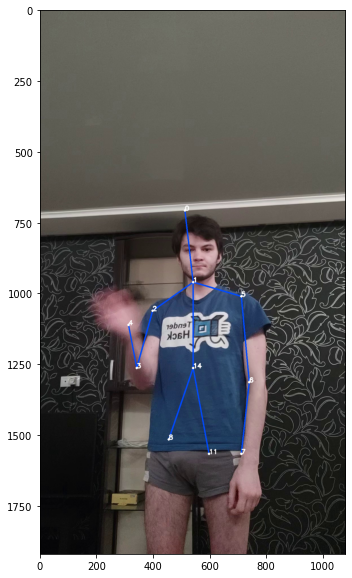

In [13]:
fig1 = plt.figure(figsize = (10,10))
plt.imshow(frame1[:,:,::-1])

### Load and run the pretrained pose estimation model on test image

In [12]:
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)

    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]
    if pose1[idFrom] and pose1[idTo]:
        cv.line(frame1, pose1[idFrom], pose1[idTo], (255, 74, 0), 3)
        cv.ellipse(frame1, pose1[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
        cv.ellipse(frame1, pose1[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
        cv.putText(frame1, str(idFrom), pose1[idFrom], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
        cv.putText(frame1, str(idTo), pose1[idTo], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)

Run the pose estimation model

In [14]:
inp = cv.dnn.blobFromImage(frame2, (1.0 / 255), (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
net.setInput(inp)
out = net.forward()

Create list of points

In [15]:
pose2 = []
for i in range(len(BODY_PARTS)):

    heatMap = out[0, i, :, :]
    _, conf, _, point = cv.minMaxLoc(heatMap)
    
    x = (frameWidth * point[0]) / out.shape[3]
    y = (frameHeight * point[1]) / out.shape[2]

    pose2.append((int(x), int(y)) if conf > 0.1 else None)

In [16]:
print (pd.DataFrame(pose2, columns=['x','y']))

        x       y
0   341.0   707.0
1   312.0   960.0
2   170.0  1010.0
3   284.0  1212.0
4   511.0  1061.0
5   397.0  1010.0
6   454.0  1263.0
7   483.0  1515.0
8   284.0  1616.0
9     NaN     NaN
10    NaN     NaN
11  426.0  1566.0
12    NaN     NaN
13    NaN     NaN
14  341.0  1313.0
15   56.0  1364.0


Plot the pose onto the test image

In [17]:
for pair in POSE_PAIRS:
    partFrom = pair[0]
    partTo = pair[1]
    assert(partFrom in BODY_PARTS)
    assert(partTo in BODY_PARTS)

    idFrom = BODY_PARTS[partFrom]
    idTo = BODY_PARTS[partTo]
    if pose2[idFrom] and pose2[idTo]:
        cv.line(frame2, pose2[idFrom], pose2[idTo], (255, 74, 0), 3)
        cv.ellipse(frame2, pose2[idFrom], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
        cv.ellipse(frame2, pose2[idTo], (4, 4), 0, 0, 360, (255, 255, 255), cv.FILLED)
        cv.putText(frame2, str(idFrom), pose2[idFrom], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)
        cv.putText(frame2, str(idTo), pose2[idTo], cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255),2,cv.LINE_AA)

### Show output

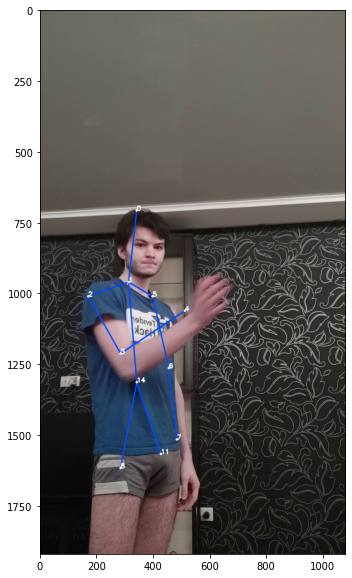

In [18]:
fig2 = plt.figure(figsize = (10,10))
plt.imshow(frame2[:,:,::-1])

### Compare similarity of poses between input and test images

Format the pose vectors into correct format

In [88]:
def set_pose_element_by_indexes(pose, indexes, set_value=(0, 0)):
    modified_pose = [x for x in pose]
    for index in indexes:
        modified_pose[index] = set_value
        
    return modified_pose
    

def normalize_broken_pose(pose, normalized_value=(0, 0)):
    normalized_pose = []
    broken_indexes = []
    for idx, pose_element in enumerate(pose):
        if pose_element is None:
            normalized_pose.append(normalized_value)
            broken_indexes.append(idx)
        else:
            normalized_pose.append(pose_element)
    
    if len(broken_indexes) == 0:
        return (normalized_pose, None)
    else:
        return (normalized_pose, broken_indexes)

In [87]:
# def similarity_score(pose1, pose2):
#     p1 = []
#     p2 = []
#     pose_1 = np.array(pose1, dtype=np.float)
#     pose_2 = np.array(pose2, dtype=np.float)

#     # Normalize coordinates
#     pose_1[:,0] = pose_1[:,0] / max(pose_1[:,0])
#     pose_1[:,1] = pose_1[:,1] / max(pose_1[:,1])
#     pose_2[:,0] = pose_2[:,0] / max(pose_2[:,0])
#     pose_2[:,1] = pose_2[:,1] / max(pose_2[:,1])

#     # L2 Normalization
# #     for joint in range(pose_1.shape[0]):
# #         mag1 = float(math.sqrt(pose_1[joint][0]**2 + pose_1[joint][1]**2))
# #         mag2 = float(math.sqrt(pose_2[joint][0]**2 + pose_2[joint][1]**2))

# #         pose_1[joint][0] = pose_1[joint][0] / mag1
# #         pose_1[joint][1] = pose_1[joint][1] / mag2
# #         pose_2[joint][0] = pose_2[joint][0] / mag2
# #         pose_2[joint][1] = pose_2[joint][1] / mag2

#     # Turn (16x2) into (32x1)
#     for joint in range(pose_1.shape[0]):
#         x1 = pose_1[joint][0]
#         y1 = pose_1[joint][1]
#         x2 = pose_2[joint][0]
#         y2 = pose_2[joint][1]

#         p1.append(x1)
#         p1.append(y1)
#         p2.append(x2)
#         p2.append(y2)

#     p1 = np.array(p1)
#     p2 = np.array(p2)

#     # Looking to minimize the distance if there is a match
#     # Computing two different distance metrics
#     scoreA = utils.cosine_distance(p1, p2)
#     scoreB = utils.weight_distance(p1, p2, conf1)

#     print("Cosine Distance:", scoreA)
#     print("Weighted Distance:", scoreB)

#### Compute a distance score between the two pose vectors

In [21]:
_, broken_idxs_pose1 = normalize_broken_pose(pose1)
_, broken_idxs_pose2 = normalize_broken_pose(pose2)

first_broken_idx_pose1, first_broken_idx_pose2 = min(broken_idxs_pose1), min(broken_idxs_pose2)
if abs(first_broken_idx_pose1 - first_broken_idx_pose2) <= 1:
    cut_idx = min(first_broken_idx_pose1, first_broken_idx_pose2)
    normalized_pose1, normalized_pose2 = pose1[:cut_idx], pose2[:cut_idx]

similarity_score(normalized_pose1, normalized_pose2)

pose1 = normalized_pose1
pose2 = normalized_pose2

#normalized_pose1 = set_pose_element_by_indexes(pose1, broken_idxs_pose2)

Cosine Distance: 0.9767401504209838
Weighted Distance: 0.13539645914587217


In [89]:
similarity_score(pose1, pose2)

IndexError: too many indices for array

#### Visualize Matching

In [23]:
def find_visualizable_pairs(pose1, pose2):
    pose_len = len(pose1)
    assert(pose_len == len(pose2))
    
    visualizable_pairs = []
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        
        if (idFrom < pose_len) and (idTo < pose_len):
            visualizable_pairs.append(pair)
            
    return visualizable_pairs

In [24]:
# def visualize_output(pose1, pose2, size):
#     assert(len(pose1) == len(pose2))
#     pose_len = len(pose1)
    
#     # Initialize blank canvas
#     canvas = np.ones(size)

#     # Plot points on images
#     for pair in POSE_PAIRS:
#         partFrom = pair[0]
#         partTo = pair[1]
#         assert(partFrom in BODY_PARTS)
#         assert(partTo in BODY_PARTS)

#         idFrom = BODY_PARTS[partFrom]
#         idTo = BODY_PARTS[partTo]
        
#         if idFrom >= pose_len:
#             continue
#         elif idTo >= pose_len:
#             continue
        
#         if pose1[idFrom] and pose1[idTo]:
#             cv.line(canvas, pose1[idFrom], pose1[idTo], (0, 255, 0), 3)
#             cv.ellipse(canvas, pose1[idFrom], (4, 4), 0, 0, 360, (0, 255, 0), cv.FILLED)
#             cv.ellipse(canvas, pose1[idTo], (4, 4), 0, 0, 360, (0, 255, 0), cv.FILLED)

#     for pair in POSE_PAIRS:
#         partFrom = pair[0]
#         partTo = pair[1]
#         assert(partFrom in BODY_PARTS)
#         assert(partTo in BODY_PARTS)

#         idFrom = BODY_PARTS[partFrom]
#         idTo = BODY_PARTS[partTo]
        
#         if idFrom >= pose_len:
#             continue
#         elif idTo >= pose_len:
#             continue
        
#         if pose2[idFrom] and pose2[idTo]:
#             cv.line(canvas, pose2[idFrom], pose2[idTo], (255, 0, 0), 3)
#             cv.ellipse(canvas, pose2[idFrom], (4, 4), 0, 0, 360, (255, 0, 0), cv.FILLED)
#             cv.ellipse(canvas, pose2[idTo], (4, 4), 0, 0, 360, (255, 0, 0), cv.FILLED)

#     # Visualize images
#     fig3 = plt.figure(figsize = (10,10))
#     plt.imshow(canvas[:,:,::-1])
#     plt.grid(True)

In [61]:
visualize_output(pose1, pose2, frame1.shape)

AssertionError: 

## Pose Matching with Affine Transformation


Another approach we tried was first finding the affine transformation to match point 1 (neck) and point 14 (the abdomen) to align the centers of the bodies

In [52]:
visualizable_pairs = find_visualizable_pairs(pose1, pose2)

NameError: name 'find_visualizable_pairs' is not defined

In [26]:
#q = np.array([[pose1[1][0]],[pose1[1][1]],[pose1[14][0]],[pose1[14][1]]], np.float)
max_idx = len(visualizable_pairs)
q = np.array([[pose1[1][0]],[pose1[1][1]],[pose1[max_idx][0]],[pose1[max_idx][1]]], np.float)

p = np.array([[pose2[1][0], pose2[1][1], 1.0, 0.0, 0.0, 0.0], \
              [0.0, 0.0, 0.0, pose2[1][0], pose2[1][1], 1.0], \
              [pose2[max_idx][0], pose2[max_idx][1], 1.0, 0.0, 0.0, 0.0], \
              [0.0, 0.0, 0.0, pose2[max_idx][0], pose2[max_idx][1], 1.0]], np.float)

A, res, rank, s = np.linalg.lstsq(p, q)

T = np.array([[A[0], A[1], A[2]],[A[3], A[4], A[5]],[0.0, 0.0, 1.0]], np.float)

NameError: name 'visualizable_pairs' is not defined

Create the new transformed second pose

In [28]:
pose2_new = []

for (i,j) in pose2:
        
        cur_pt = np.array([i,j,1])
        transformed_pt = T.dot(cur_pt)
        
        transformed_pt = transformed_pt / transformed_pt[2]
        pose2_new.append((int(transformed_pt[0]), int(transformed_pt[1])))

#### Compare similarity between the poses

In [29]:
similarity_score(pose1, pose2_new)

Cosine Distance: 0.5705056633776034
Weighted Distance: 0.7312858937175111


#### Visualize the result

In [63]:
visualize_output(pose1, pose2_new, frame1.shape)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Pose Matching after Cropping and Scaling

Crop and resize the poses to the same size and then check for similarity

In [53]:
def crop_and_resize_matching(pose1, pose2):
    pose1_new = np.array(pose1)
    pose2_new = np.array(pose2)

    pose1_new[:,0] = pose1_new[:,0] - min(pose1_new[:,0])
    pose1_new[:,1] = pose1_new[:,1] - min(pose1_new[:,1])

    pose2_new[:,0] = pose2_new[:,0] - min(pose2_new[:,0])
    pose2_new[:,1] = pose2_new[:,1] - min(pose2_new[:,1])
    
    resize_x = max(pose2_new[:,0])/max(pose1_new[:,0])
    resize_y = max(pose2_new[:,1])/max(pose1_new[:,1])

    pose1_new[:,0] = pose1_new[:,0] * resize_x
    pose1_new[:,1] = pose1_new[:,1] * resize_y
    
    return (pose1_new, pose2_new, similarity_score(pose1_new, pose2_new))

In [54]:
pose1_new, pose2_new, score = crop_and_resize_matching(pose1, pose2)

Cosine Distance: 0.9417237434827384
Weighted Distance: 0.2527445887445887


Compute the new similarity scores

Visualize the result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


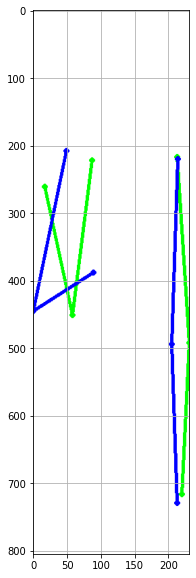

In [55]:
pose1_resized = tuple(map(tuple, pose1_new))
pose2_resized = tuple(map(tuple, pose2_new))

# Get dimensions of output window
pose_1 = np.array(pose1_new)
pose_2 = np.array(pose2_new)
max_y = max(max(pose_1[:,0]), max(pose_2[:,0]))
max_x = max(max(pose_1[:,1]), max(pose_2[:,1]))
dim = (max_x, max_y, 3) 
visualize_output(pose1_resized, pose2_resized, dim)

## Camera

In [56]:
expected_pose = [cv.imread(str(pic_path)) for pic_path in list(sorted(SHORT_NEXT_1FORWARD.glob(FRAME_PATTERN)))]

In [64]:
# TEST VIDEO

cap = cv.VideoCapture(0)
# detector = poseDetector()

overall_sum = 0.0
amount = 0
while True:
# for frame in expected_pose:
    start_time = time.time()
    
    success, frame = cap.read()
    
    frame = detector.findPose(frame)
    lm_list = detector.findPosition(frame, draw=False)
    
    pose = [(x, y) for (idx, x, y) in lm_list]
    conf = [1.0 for x in pose1]
    
    
    print(len(pose))
    crop_and_resize_matching(pose, pose)
    #inp = cv.dnn.blobFromImage(frame1, (1.0 / 255), (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)
    #net.setInput(inp)
    #out = net.forward()
    
    end_time = time.time()
    
    amount += 1
    diff = (end_time - start_time)
    fps = int(round(1.0 / diff))
    overall_sum += fps
    print(f"{1000 * diff}ms | {fps}fps | {overall_sum / amount} avg fps")

25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
289.8087501525879ms | 3fps | 3.0 avg fps
25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
67.04378128051758ms | 15fps | 9.0 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
83.15253257751465ms | 12fps | 10.0 avg fps
25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
87.4474048614502ms | 11fps | 10.25 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
101.16100311279297ms | 10fps | 10.2 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
119.4303035736084ms | 8fps | 9.833333333333334 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
140.20991325378418ms | 7fps | 9.428571428571429 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
140.40160179138184ms | 7fps | 9.125 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
160.29787063598633ms | 6fps | 8.777777777777779 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
148.924827575683

25
Cosine Distance: 1.0
Weighted Distance: 0.0
120.14460563659668ms | 8fps | 7.3544303797468356 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
98.84405136108398ms | 10fps | 7.3875 avg fps
25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
160.89963912963867ms | 6fps | 7.37037037037037 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
125.6253719329834ms | 8fps | 7.378048780487805 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
86.01212501525879ms | 12fps | 7.433734939759036 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
88.85049819946289ms | 11fps | 7.476190476190476 avg fps
25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
62.55388259887695ms | 16fps | 7.576470588235294 avg fps
25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
57.51991271972656ms | 17fps | 7.686046511627907 avg fps
25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
63.773393630981445ms | 16fps | 7.781609195402299 avg fps
25
Cosine

25
Cosine Distance: 1.0
Weighted Distance: 0.0
120.48578262329102ms | 8fps | 7.525974025974026 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
121.57297134399414ms | 8fps | 7.529032258064516 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
120.45145034790039ms | 8fps | 7.532051282051282 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
163.31720352172852ms | 6fps | 7.522292993630574 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
150.66957473754883ms | 7fps | 7.518987341772152 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
94.58088874816895ms | 11fps | 7.540880503144654 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
79.04982566833496ms | 13fps | 7.575 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
135.03265380859375ms | 7fps | 7.571428571428571 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
108.12664031982422ms | 9fps | 7.580246913580247 avg fps
25
Cosine Distance: 1.0
W

25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
161.46516799926758ms | 6fps | 7.9126637554585155 avg fps
25
Cosine Distance: 0.9999999999999999
Weighted Distance: 0.0
166.49508476257324ms | 6fps | 7.904347826086957 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
115.48161506652832ms | 9fps | 7.909090909090909 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
130.69868087768555ms | 8fps | 7.9094827586206895 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
137.4211311340332ms | 7fps | 7.905579399141631 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
152.65679359436035ms | 7fps | 7.901709401709402 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
179.45480346679688ms | 6fps | 7.8936170212765955 avg fps
25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
181.1819076538086ms | 6fps | 7.885593220338983 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
130.9671401977539ms | 8fps | 7.8860759

25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
84.90204811096191ms | 12fps | 7.928104575163399 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
116.49227142333984ms | 9fps | 7.931596091205212 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
131.89983367919922ms | 8fps | 7.931818181818182 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
137.7418041229248ms | 7fps | 7.9288025889967635 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
126.71685218811035ms | 8fps | 7.929032258064516 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
147.28116989135742ms | 7fps | 7.92604501607717 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
156.5847396850586ms | 6fps | 7.919871794871795 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
180.29069900512695ms | 6fps | 7.913738019169329 avg fps
25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
132.8568458557129ms | 8fps | 7.914012738853503 avg fps
25
Cosine Distance: 1.000000000

25
Cosine Distance: 1.0
Weighted Distance: 0.0
138.4885311126709ms | 7fps | 8.00262467191601 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
131.20007514953613ms | 8fps | 8.002617801047121 avg fps
25
Cosine Distance: 0.9999999999999998
Weighted Distance: 0.0
133.74924659729004ms | 7fps | 8.0 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
105.49664497375488ms | 9fps | 8.002604166666666 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
61.53392791748047ms | 16fps | 8.023376623376624 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
58.92229080200195ms | 17fps | 8.046632124352332 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.0
66.51687622070312ms | 15fps | 8.064599483204134 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
59.55362319946289ms | 17fps | 8.087628865979381 avg fps
25
Cosine Distance: 1.0
Weighted Distance: 0.0
59.0665340423584ms | 17fps | 8.110539845758355 avg fps
25
Cosine Distance: 1.0000000000000002
Weighted Distance: 0.

KeyboardInterrupt: 